## Importando as libs usadas no processo

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pprint import pprint


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import precision_score


from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost.sklearn import XGBClassifier

from sklearn.naive_bayes import GaussianNB

## Impontando os arquivos para gerar os DataFrames usados

In [2]:
df_target_user = pd.read_csv('/content/drive/Shared drives/iniciacao_cientifica_2019_2020/csv_datasets/usuarios_classificados.csv')
df_target_user = df_target_user[['semester_id', 'class_id', 'user_id', 'target']]

file_path = '/content/drive/Shared drives/iniciacao_cientifica_2019_2020/dataframes_treino/turmas_impares/dataset.xlsx'
df_dataset = pd.read_excel(file_path, sheet_name=0)
df_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
df_dataset.fillna(0, inplace=True)
df_dataset.class_id.unique().shape

df_data_target = pd.merge(df_dataset, df_target_user, on=['semester_id', 'class_id', 'user_id'], how='inner')
df_data_target.drop(['semester_id', 'class_id', 'user_id'], axis=1, inplace=True)    
df_data_target

,number_logins,average_active_time,average_exam_sub_comp,average_exam_sub_inc,average_exam_sub_err,average_exam_sub_mean_time,average_exam_test,average_exam_test_err,average_exam_test_mean_time,average_exam_code_line,average_homework_sub_comp,average_homework_sub_inc,average_homework_sub_err,average_homework_sub_mean_time,average_homework_test,average_homework_test_err,average_homework_test_mean_time,average_homework_code_line,sum_exam_sub_comp,sum_exam_sub_inc,sum_exam_sub_err,sum_exam_sub_mean_time,sum_exam_test,sum_exam_test_err,sum_exam_test_mean_time,sum_exam_code_line,sum_homework_sub_comp,sum_homework_sub_inc,sum_homework_sub_err,sum_homework_sub_mean_time,sum_homework_test,sum_homework_test_err,sum_homework_test_mean_time,sum_homework_code_line,target
0,4,1566.0000,0.0000,0.0,0.0000,0.0000,8.0000,8.0000,89.8570,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0.0000,8,8,89.857,1,0,0,0,0.0000,0,0,0.000,0,Desistente
1,24,749.6667,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0833,1.0833,0.7500,95.4266,5.6667,3.0000,50.6084,6.1667,0,0,0,0.0000,0,0,0.000,0,13,13,9,1145.1190,68,36,607.301,74,Desistente
2,2,24.2500,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.8333,0,0,0,0.0000,0,0,0.000,0,12,0,0,0.0000,0,0,0.000,82,Desistente
3,45,72.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8000,0.0000,0.8000,7.8000,0.0000,0.0000,0.0000,6.2000,0,0,0,0.0000,0,0,0.000,0,4,0,4,39.0000,0,0,0.000,31,Desistente
4,19,942.0909,1.0000,1.5,0.1667,325.6389,10.6667,3.8333,58.3365,11.8333,1.0000,3.1111,0.9630,1168.2505,12.2222,4.7407,669.4558,9.7778,6,9,1,1953.8333,64,23,350.019,71,27,84,26,31542.7644,330,128,18075.306,264,Não Desistente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,45,985.5000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,4.5000,0.5000,27.2222,7.5000,4.0000,40.5000,16.0000,0,0,0,0.0000,0,0,0.000,0,1,9,1,54.4444,15,8,81.000,32,Desistente
2006,24,966.3611,1.1667,12.5,3.0000,112.0596,23.6667,6.5000,67.5647,17.3333,1.2667,2.9667,2.4667,1199.4363,6.5333,3.2000,96.7261,11.2000,7,75,18,672.3577,142,39,405.388,104,38,89,74,35983.0877,196,96,2901.784,336,Não Desistente
2007,41,617.8095,0.2000,6.6,2.8000,126.0825,12.4000,5.4000,99.5218,14.6000,1.1622,0.2703,0.4054,2100.0757,2.0000,0.5405,109.5970,15.1892,1,33,14,630.4125,62,27,497.609,73,43,10,15,77702.8000,74,20,4055.088,562,Não Desistente
2008,20,409.8571,0.4000,6.2,0.4000,38.0143,18.2000,6.6000,59.3428,15.4000,1.0000,1.0811,0.4595,430.1190,0.4595,0.1081,2.0734,11.2703,2,31,2,190.0714,91,33,296.714,77,37,40,17,15914.4012,17,4,76.714,417,Não Desistente


## Separando os dados treino até 3º prova

In [3]:
# get the features antil the first exam
features = df_data_target.columns.difference(['target'])
X = df_data_target[features].values
Y = df_data_target['target'].values

df_all_predictions = pd.DataFrame()
df_all_predictions['target'] = Y

### Random Forest

[Tuning o modelo](https://https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [4]:
#@title
acur_rf = []
f1_macro = []
f1_micro = []
dict_predict_rf = {}

# model
classifier_rf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=5, n_estimators=25, verbose=0)

# cv = KFold(n_splits=10,  random_state=2**32 - 1, shuffle=True)
cv = KFold(n_splits=10, shuffle=True)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]

    # fit model
    classifier_rf.fit(X_train, y_train)

    # testing model
    y_predict_rf  = classifier_rf.predict(X_test)

    # dataframe predictions
    d = dict(zip(test_index, y_predict_rf))
    dict_predict_rf.update(d)

    # acum accurary
    acur_rf.append(accuracy_score(y_test, y_predict_rf))
    f1_macro.append(f1_score(y_test, y_predict_rf, average='macro'))
    f1_micro.append(f1_score(y_test, y_predict_rf, average='micro'))
    
print('Acurácia Média Random Forest:', np.mean(acur_rf))
print('F1 macro média:', np.mean(f1_macro))
print('F1 micro média:', np.mean(f1_micro))

d = dict(sorted(dict_predict_rf.items()))
a = np.array([w for v,w in d.items()])
df_all_predictions['random_forest'] = a

Acurácia Média Random Forest: 0.9487562189054728
F1 macro média: 0.9410750500519839
F1 micro média: 0.9487562189054728


### Extra Tree Classifier

In [5]:
#@title
acur_etc = []
dict_predict_etc = {}

# model
classifier_etc = ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_depth=3, n_estimators=25)

# cv = KFold(n_splits=10,  random_state=2**32 - 1, shuffle=True)
cv = KFold(n_splits=10, shuffle=True)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]

    # fit model
    classifier_etc.fit(X_train, y_train)

    # testing model
    y_predict_etc = classifier_etc.predict(X_test)

    # dataframe predictions
    d = dict(zip(test_index, y_predict_etc))
    dict_predict_etc.update(d)

    # acum accurary
    acur_etc.append(accuracy_score(y_test, y_predict_etc))    
    
print('Acurácia Média Extra Tree Classifier:', np.mean(acur_etc))

d = dict(sorted(dict_predict_etc.items()))
a = np.array([w for v,w in d.items()])
df_all_predictions['extra_tree'] = a


Acurácia Média Extra Tree Classifier: 0.909452736318408


### XGBoost com early_stopping_rounds

In [6]:
#@title
acur_xgb_we = []
dict_predict_xgb_we = {}

# model
classifier_xgb_we = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=60, verbosity=0)

# cv = KFold(n_splits=10,  random_state=2**32 - 1, shuffle=True)
cv = KFold(n_splits=10, shuffle=True)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]

    # criando um particao de validação para o modelo xgb
    X_val, y_val = X_train[0:2], y_train[0:2]

    # fit model
    classifier_xgb_we.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=False)

    # testing model

    y_predict_xgb_we = classifier_xgb_we.predict(X_test)

    # dataframe predictions
    d = dict(zip(test_index, y_predict_xgb_we))
    dict_predict_xgb_we.update(d)

    # acum accurary
    acur_xgb_we.append(accuracy_score(y_test, y_predict_xgb_we))
    
print('Acurácia Média XGBoost com early_stopping_rounds', np.mean(acur_xgb_we))

d = dict(sorted(dict_predict_xgb_we.items()))
a = np.array([w for v,w in d.items()])
df_all_predictions['xgb_early_stopping'] = a


Acurácia Média XGBoost com early_stopping_rounds 0.9333333333333333


### XGBoost sem early_stopping_rounds

In [7]:
#@title
acur_xgb_ne = []
dict_predict_xgb_ne = {}

# model
classifier_xgb_ne = XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=60, verbosity=0)

# cv = KFold(n_splits=10,  random_state=2**32 - 1, shuffle=True)
cv = KFold(n_splits=10, shuffle=True)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]

    # fit model
    classifier_xgb_ne.fit(X_train, y_train, verbose=False)

    # testing model

    y_predict_xgb_ne = classifier_xgb_ne.predict(X_test)

    # dataframe predictions
    d = dict(zip(test_index, y_predict_xgb_ne))
    dict_predict_xgb_ne.update(d)

    # acum accurary
    acur_xgb_ne.append(accuracy_score(y_test, y_predict_xgb_ne))
    
print('Acurácia Média XGBoost sem early_stopping_rounds', np.mean(acur_xgb_ne))

d = dict(sorted(dict_predict_xgb_ne.items()))
a = np.array([w for v,w in d.items()])
df_all_predictions['xgb'] = a


Acurácia Média XGBoost sem early_stopping_rounds 0.9542288557213929


### Gaussian Naive Bayes

In [8]:
#@title
acur_gnb = []
dict_predict_gnb = {}

# model
classifier_gnb = GaussianNB()

# cv = KFold(n_splits=10,  random_state=2**32 - 1, shuffle=True)
cv = KFold(n_splits=10, shuffle=True)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]

    # fit model
    classifier_gnb.fit(X_train, y_train)

    # testing model
    y_predict_gnb = classifier_gnb.predict(X_test)

    # dataframe predictions
    d = dict(zip(test_index, y_predict_gnb))
    dict_predict_gnb.update(d)

    # acum accurary
    acur_gnb.append(accuracy_score(y_test, y_predict_gnb))

print('Acurácia Média Gaussian Naive Bayes', np.mean(acur_gnb))

d = dict(sorted(dict_predict_gnb.items()))
a = np.array([w for v,w in d.items()])
df_all_predictions['gaussian_naive_bayes'] = a


Acurácia Média Gaussian Naive Bayes 0.9054726368159205


In [9]:
df_all_predictions

,target,random_forest,extra_tree,xgb_early_stopping,xgb,gaussian_naive_bayes
0,Desistente,Desistente,Desistente,Desistente,Desistente,Desistente
1,Desistente,Desistente,Desistente,Desistente,Desistente,Desistente
2,Desistente,Desistente,Desistente,Desistente,Desistente,Desistente
3,Desistente,Desistente,Desistente,Desistente,Desistente,Desistente
4,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente
...,...,...,...,...,...,...
2005,Desistente,Desistente,Desistente,Desistente,Desistente,Desistente
2006,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente
2007,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente
2008,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente,Não Desistente


In [14]:
#@title
def plot_confusion_matrix(cm, classes=['Desistente', 'Não Desistente'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        # print('Confusion matrix, without normalization')

    #print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 18)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 10)
    plt.yticks(tick_marks, classes, size = 10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 15)
    plt.xlabel('Predicted label', size = 15)

# Confusion matrix
# cm = confusion_matrix(y_test, y_predict)
#plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
#                      title = 'Health Confusion Matrix')
# plot_confusion_matrix(cm, classes = ['Desistente', 'Não Desistente'],
#                      title = 'Confusion Matrix')
# plt.savefig('cm.png')

def confusion_matrix(df_all_predictions):
    #l = [] 
    i = 0
    for modelo in df_all_predictions.columns:
        tp = df_all_predictions[(df_all_predictions[modelo] == 'Desistente') & (df_all_predictions['target'] == 'Desistente')].shape[0]
        tn = df_all_predictions[(df_all_predictions[modelo] == 'Não Desistente') & (df_all_predictions['target'] =='Não Desistente')].shape[0]
        fp = df_all_predictions[(df_all_predictions[modelo] == 'Desistente') & (df_all_predictions['target'] == 'Não Desistente')].shape[0]
        fn = df_all_predictions[(df_all_predictions[modelo] == 'Não Desistente') & (df_all_predictions['target'] == 'Desistente')].shape[0]
        m = [[tp, fn], [fp, tn]]
        #l.append(m)
        if modelo != 'target':
            print('Modelo', i, '=', modelo)
        i += 1
        cm = metrics.confusion_matrix(df_all_predictions['target'].values, df_all_predictions[modelo].values)
        plot_confusion_matrix(cm)

Modelo 1 = random_forest
Modelo 2 = extra_tree
Modelo 3 = xgb_early_stopping
Modelo 4 = xgb
Modelo 5 = gaussian_naive_bayes


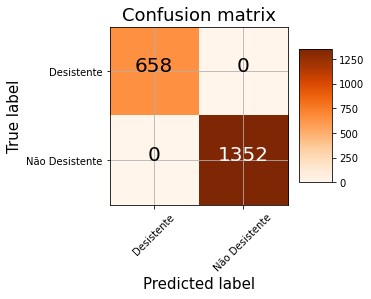

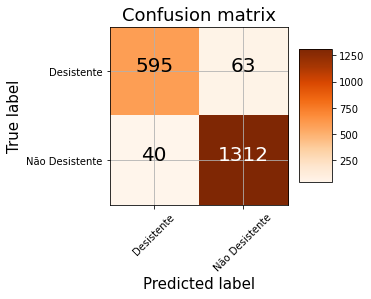

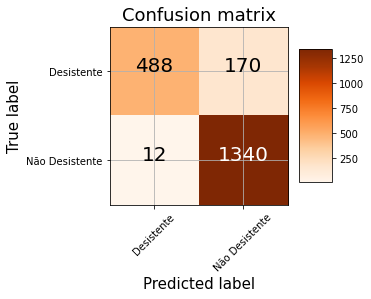

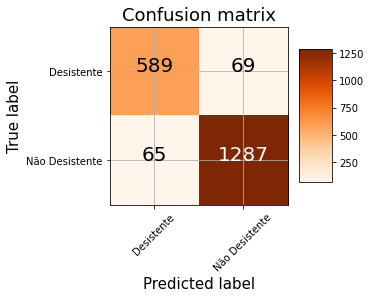

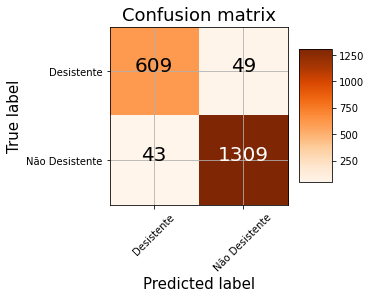

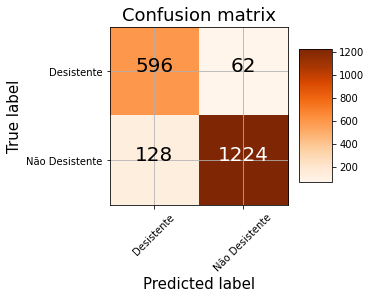

In [15]:
confusion_matrix(df_all_predictions)

## Exportando o resultado para um excel

from pandas import ExcelWriter
 
writer = ExcelWriter('/content/drive/Shared drives/iniciacao_cientifica_2019_2020/dataframes_experimento/e1.1/treino_com_desistentes.xlsx')
df_rf_all_predictions.to_excel(writer, 'random_forest')
df_etc_all_predictions.to_excel(writer, 'extra_tree_classifier')
df_xgb_we_all_predictions.to_excel(writer, 'xgboost_com_early_stopping')
df_xgb_ne_all_predictions.to_excel(writer, 'xgboost_sem_early_stopping')
df_gnb_all_predictions.to_excel(writer, 'gaussian_naive_bayes')\
 
writer.save()